# Boltzmann-corrected Ehrenfest dynamics (ala "Bastida" method)


## 1. General Setups 

First, lets import all necessary modules, including Matplotlib for plotting

Also, define parameters for plotting, including colors

In [1]:
import os
import sys
import math
import copy

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import units
import libra_py.workflows.nbra.step4 as step4


import matplotlib.pyplot as plt   # plots
%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::complex<double>, std::allocator<std::complex<double> > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, s

Another auxiliary function for plotting

In [2]:
def plot(res):
    nsteps = res.num_of_rows
    
    # Convert the results to lists format    
    t = []
    shE, shP0, shP1 = [], [], []
    seE, seP0, seP1 = [], [], []
    
    for i in range(nsteps):
        t.append(res.get(i, 0)*units.au2fs )  # time
        shE.append(res.get(i, 8))   # SH-weighted energy
        shP0.append(res.get(i, 3))  # SH pop of state 0
        shP1.append(res.get(i, 6))  # SH pop of state 1
    
        seE.append(res.get(i, 7))   # SE-weighted energy
        seP0.append(res.get(i, 2))  # SE pop of state 0
        seP1.append(res.get(i, 5))  # SE pop of state 1
        
    # Do the plotting
    plt.figure(1, figsize=(18, 12)) # dpi=300, frameon=False)
    plt.subplot(2,2,1)
    plt.title('Schrodinger Equation')
    plt.xlabel('Time, fs')
    plt.ylabel('Energy, a.u.')
    plt.plot(t, seE, label='', linewidth=2, color = colors["11"]) 

    plt.subplot(2,2,2)
    plt.title('Surface Hopping')
    plt.xlabel('Time, fs')
    plt.ylabel('Energy, a.u.')
    plt.plot(t, shE, label='', linewidth=2, color = colors["11"]) 

    plt.subplot(2,2,3)
    plt.xlabel('Time, fs')
    plt.ylabel('Population')
    plt.plot(t, seP0, label='SE 0', linewidth=2, color = colors["21"]) 
    plt.plot(t, seP1, label='SE 1', linewidth=2, color = colors["31"]) 

    plt.subplot(2,2,4)
    plt.xlabel('Time, fs')
    plt.ylabel('Population')
    plt.plot(t, shP0, label='SH 0', linewidth=2, color = colors["21"]) 
    plt.plot(t, shP1, label='SH 1', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.show()
    plt.close()
        
    

In [3]:
def test_pops(Hvib, res, T):
    # Print out the info about the equilibrium
    E0 = Hvib[0][0].get(0,0).real
    E1 = Hvib[0][0].get(1,1).real
    boltz_ratio = math.exp(-(E1-E0)/(units.kB*T))
    
    i = res.num_of_rows - 1
    shP0 = res.get(i, 3)  # SH pop of state 0
    shP1 = res.get(i, 6)  # SH pop of state 1        
    seP0 = res.get(i, 2)  # SE pop of state 0
    seP1 = res.get(i, 5)  # SE pop of state 1
    
    print( "Expected Boltzman populations factor, total pop on state 1 / total pot on stat 0 ", boltz_ratio)
    print( "actual ratio of the SH populations on the two states, at equilibrium = ", shP1/shP0)
    print( "actual ratio of the SE populations on the two states, at equilibrium = ", seP1/seP0)

Here is where we define our model. For this model, we can denerate the Hvib matrices along the pre-computed trajectories (the NBRA assumption). NBRA = neglect of back-reaction approximation. 

In this example, we only imagine a system evolving in time such that the adiabatic energies and non-adiabatic couplings are constant for all times - really the simplest model problem. Well, in reality, this may be not that simple to realise, but we don't care here.

We generate a single data set (one "trajectory") - that's why len(Hvib) == 1 

The trajectory comprises nsteps = 500 nuclear timesteps

Adiabatic energy levels are at -0.001 and 0.001 a.u. and the NAC is at 0.005 a.u. as well

In [4]:
nsteps = 500

# Populate Hvib - this is our model
Hvib = []
hvib = []
for i in range(nsteps):
    hvib.append(CMATRIX(2,2))
    hvib[i].set(0,0,-0.000+0.0j);   hvib[i].set(0,1, 0.0+0.005j);
    hvib[i].set(1,0, 0.0-0.005j);   hvib[i].set(1,1, 0.001+0.0j);
Hvib.append(hvib)

Now, lets set up all the simulation parameters: most of them are going to be similar to the parameters described in other tutorials.

Here, we focus only on what is relevant to our case (Boltzmann-corrected Ehrenfest)

In [5]:
# Standanrd parameters
params = {}
params.update({"T":300.0, "ntraj":1000, "dt":1.0*units.fs2au, "nsteps":nsteps})
params.update({"istate":1, "init_times":[0], "outfile":"_out.txt", "data_set_paths":[""]})

# Accepted hopping - all transitions, because thermal is taken care of in the Bastida method
params["Boltz_opt"] = 0 

# Proposed hopping is according to quantum populations
params["sh_method"] = 0

# To turn the Bastida method on, use the following option
params["tdse_Ham"] = 1

# The vibronic Hamiltonian (before thermal correction) is in the adiabatic basis
params["Hvib_type"] = 1  


Next, we will explore the combinations of various decoherence schemes with the Bastida method


## 2. No decoherence

In [6]:
params["decoherence_method"] = 0

Now, lets run the TSH calculations.

The output is a nsteps x 10 matrix, wich contains all sorts of information - energies, populations, different types of weighted sums. The example format for a 2-state calculation is shown below.

In [7]:
# nstates = 2 => n_cols = 2*3 + 4 = 11
#        0    1      2     3    4      5      6     7     8    9    10
# res =  t   E0, P_SE0, P_SH0, E1, P_SE1, P_SH1, E_SE, E_SH, P_SE, P_SH
res = step4.run(Hvib, params)

Decoherence times matrix (a.u. of time):
Decoherence times matrix (fs):
Decoherence rates matrix (a.u.^-1):


The nsteps x 10 matrix returned above needs to be uppacked so that the resulting Python lists could be used in plotting with matplotlib.

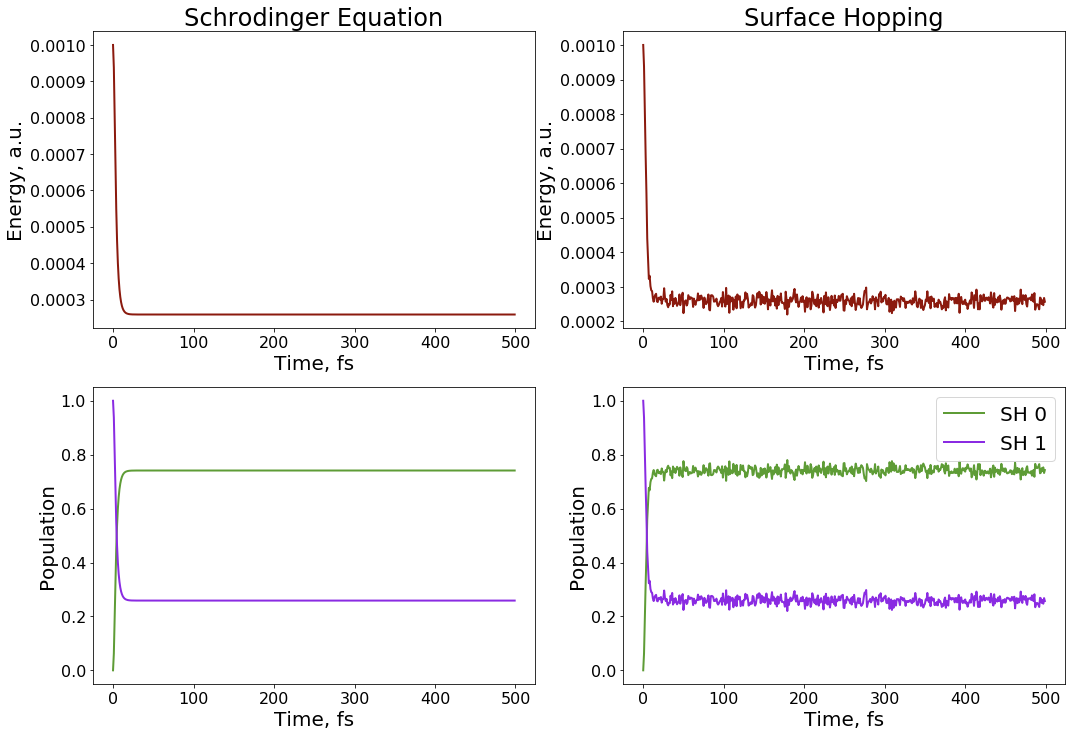

In [8]:
plot(res)

We can now also look at the relative population of the two states when the system reaches termal equilibrium. Do the computed populations agree with what is expected from the Boltzmann distribution?

In [9]:
test_pops(Hvib, res, params["T"])

Expected Boltzman populations factor, total pop on state 1 / total pot on stat 0  0.3490352972977542
actual ratio of the SH populations on the two states, at equilibrium =  0.3458950201884253
actual ratio of the SE populations on the two states, at equilibrium =  0.349035297297751


## 3. MSDM

### 3.1. Decoherence time = 1 fs

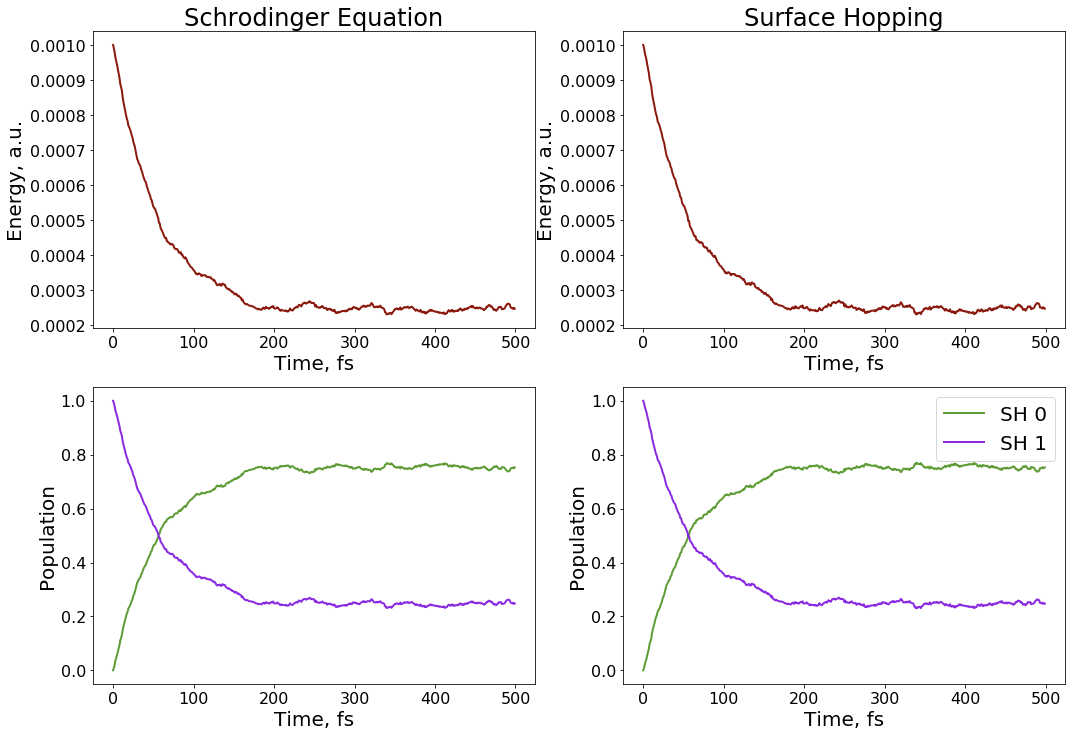

Expected Boltzman populations factor, total pop on state 1 / total pot on stat 0  0.3490352972977542
actual ratio of the SH populations on the two states, at equilibrium =  0.3280212483399734
actual ratio of the SE populations on the two states, at equilibrium =  0.3287304123916079


In [10]:
params["decoherence_method"] = 2
params["decoherence_constants"] = 1   # decoherence times from the data
t = 1.0 * units.fs2au
tau = MATRIX(2,2)
tau.set(0,1, t); tau.set(1,0, t)
params["decoherence_times"] = tau

res = step4.run(Hvib, params)
plot(res)
test_pops(Hvib, res, params["T"])

### 3.2. Decoherence time = 10 fs

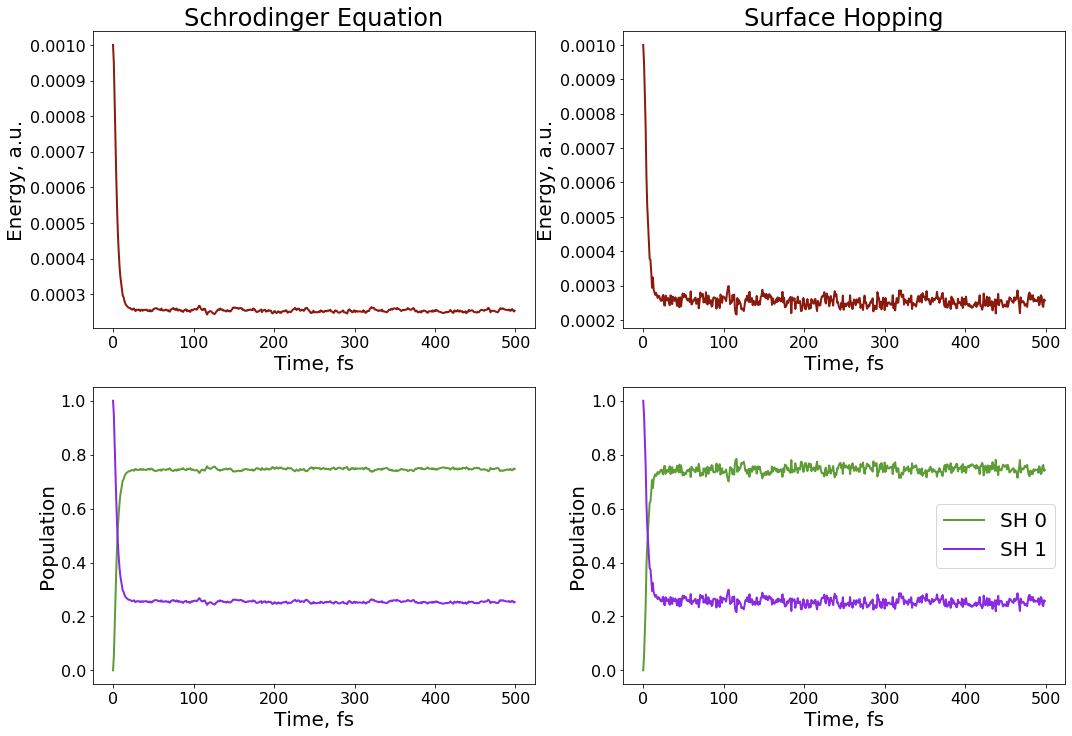

Expected Boltzman populations factor, total pop on state 1 / total pot on stat 0  0.3490352972977542
actual ratio of the SH populations on the two states, at equilibrium =  0.3458950201884253
actual ratio of the SE populations on the two states, at equilibrium =  0.3395800377083253


In [11]:
params["decoherence_method"] = 2
params["decoherence_constants"] = 1   # decoherence times from the data
t = 10.0 * units.fs2au
tau = MATRIX(2,2)
tau.set(0,1, t); tau.set(1,0, t)
params["decoherence_times"] = tau

res = step4.run(Hvib, params)
plot(res)
test_pops(Hvib, res, params["T"])

## 4. DISH

### 4.1. Decoherence time = 1 fs

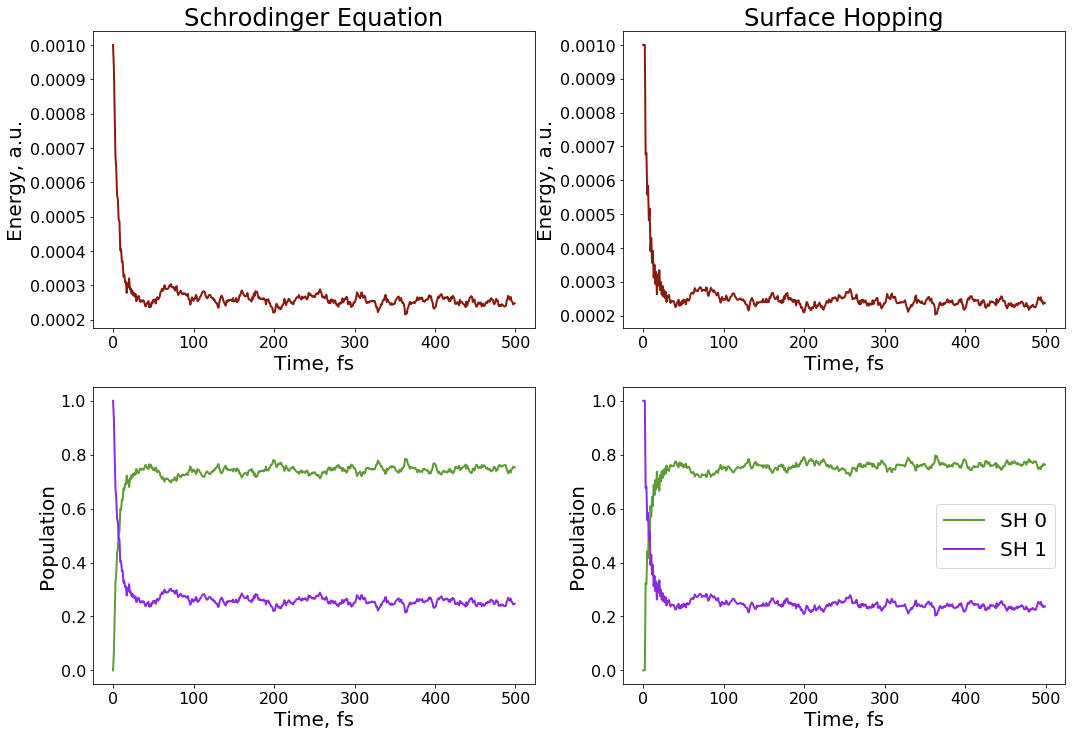

Expected Boltzman populations factor, total pop on state 1 / total pot on stat 0  0.3490352972977542
actual ratio of the SH populations on the two states, at equilibrium =  0.3106159895150721
actual ratio of the SE populations on the two states, at equilibrium =  0.3287189718037045


In [12]:
params["decoherence_method"] = 3
params["decoherence_constants"] = 1   # decoherence times from the data
t = 1.0 * units.fs2au
tau = MATRIX(2,2)
tau.set(0,1, t); tau.set(1,0, t)
params["decoherence_times"] = tau

res = step4.run(Hvib, params)
plot(res)
test_pops(Hvib, res, params["T"])

### 4.2. Decoherence time = 10 fs

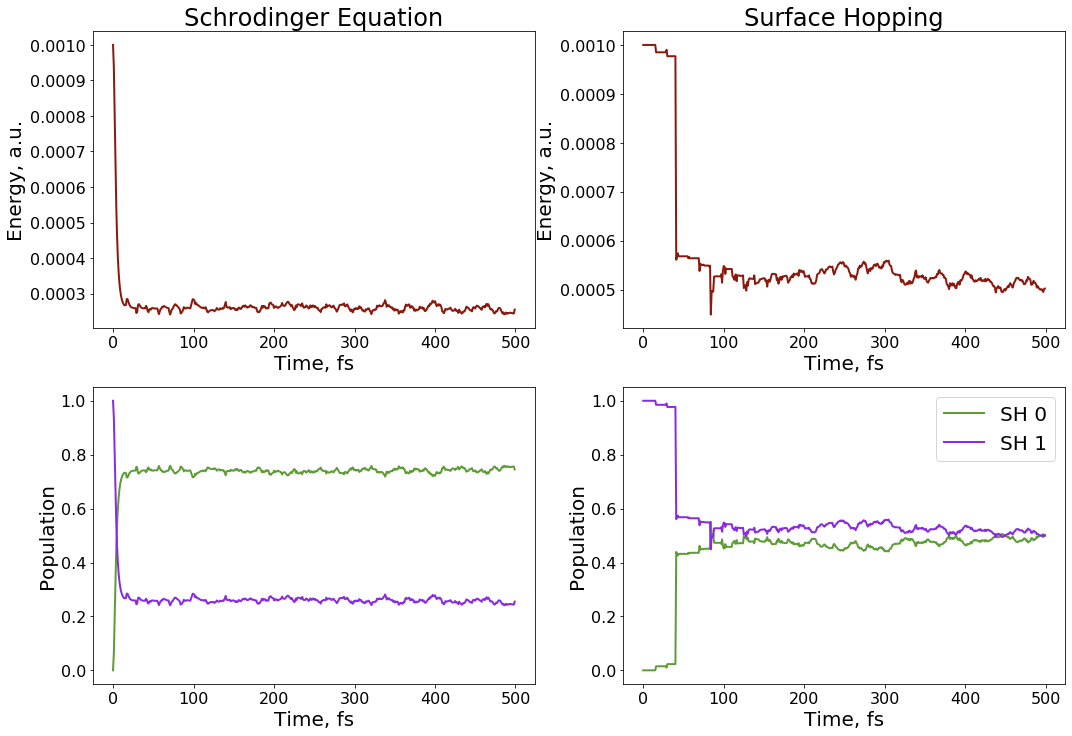

Expected Boltzman populations factor, total pop on state 1 / total pot on stat 0  0.3490352972977542
actual ratio of the SH populations on the two states, at equilibrium =  1.008032128514056
actual ratio of the SE populations on the two states, at equilibrium =  0.34199697474065394


In [13]:
params["decoherence_method"] = 3
params["decoherence_constants"] = 1   # decoherence times from the data
t = 10.0 * units.fs2au
tau = MATRIX(2,2)
tau.set(0,1, t); tau.set(1,0, t)
params["decoherence_times"] = tau

res = step4.run(Hvib, params)
plot(res)
test_pops(Hvib, res, params["T"])